In [4]:
import os
import re
import glob
import natsort
import pymbar
import alchemlyb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from pymbar.timeseries import detect_equilibration, subsample_correlated_data
from alchemlyb.preprocessing import subsampling
from alchemlyb.estimators import MBAR
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.visualisation import plot_mbar_overlap_matrix

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})

# Set the font used for MathJax - more on this print(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

In [7]:
# number of replicas
N = 6
# simulation temperature
T = 300

dhdl_dir = 'dhdl_files'

folders = [f'{dhdl_dir}/state_{i}' for i in range(N)]
u_nk_data = []
for i in range(N):
    files = glob.glob(os.path.join(folders[i], '*dhdl*xvg*'))
    files = natsort.natsorted(files, reverse=False)
    print(f' Collecting data for the following files: {", ".join(files)}')
    u_nk = alchemlyb.concat([extract_u_nk(xvg, T=T) for xvg in files])
    u_nk_series = subsampling.u_nk2series(u_nk)
    u_nk, u_nk_series = subsampling._prepare_input(u_nk, u_nk_series, drop_duplicates=True, sort=True)
    u_nk = subsampling.slicing(u_nk, step=1)
    u_nk_series = subsampling.slicing(u_nk_series, step=1)

    t, statinef, Neff_max = detect_equilibration(u_nk_series.values)
    u_nk_series_equil, u_nk_equil = u_nk_series[t:], u_nk[t:]
    indices = subsample_correlated_data(u_nk_series_equil, g=statinef)
    preprocessed_u_nk = u_nk_equil.iloc[indices]
    u_nk_data.append(preprocessed_u_nk)

u_nk_data = alchemlyb.concat(u_nk_data)
print(' Fitting MBAR on u_nk ...')
try:
    mbar_stop = False
    mbar = MBAR().fit(u_nk_data)
except pymbar.utils.ParameterError():
    mbar_stop = True
    print("\sum_n W_nk is not equal to 1, probably due to insufficient overlap between states.")
    print("Stop using MBAR ...")

if mbar_stop is False:
    print(f" MBAR: {mbar.delta_f_.iloc[0, -1]:.4f} +/- {mbar.d_delta_f_.iloc[0, -1]:.4f} kT")


 Fitting MBAR on u_nk ...
 MBAR: -15.1593 +/- 0.0136 kT


/Users/starwingchen/anaconda3/envs/AmberTools20/lib/python3.9/site-packages/alchemlyb/estimators/mbar_.py:125: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  (len(groups.get_group(i)) if i in groups.groups else 0)
/Users/starwingchen/anaconda3/envs/AmberTools20/lib/python3.9/site-packages/alchemlyb/estimators/bar_.py:97: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  (len(groups.get_group(i)) if i in groups.groups else 0)
/Users/starwingchen/anaconda3/envs/AmberTools20/lib/python3.9/site-packages/alchemlyb/estimators/bar_.py:106: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instea

<Axes: >

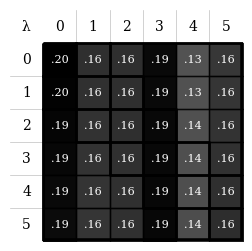

In [8]:
plot_mbar_overlap_matrix(mbar.overlap_matrix)

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})

# Set the font used for MathJax - more on this
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')


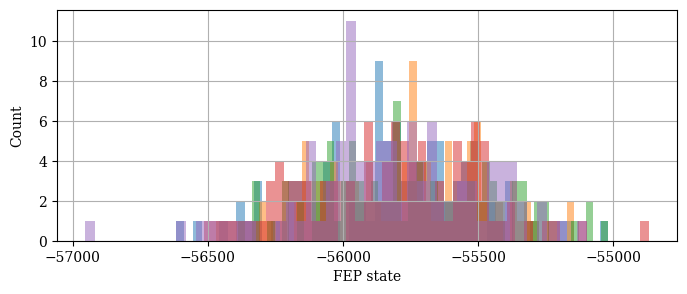

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Load and transpose the data from the specified files
HREMD_data = [np.transpose(np.loadtxt(f'state_{i}/dhdl.part0001.xvg', comments=['@', '#'])) for i in range(5)]

# Extract the second row of each dataset
dist_list = [data[1] for data in HREMD_data]

# Plotting histograms
plt.figure(figsize=(8, 3))
for i in range(5):  # Change range to 5 since we only have 5 datasets
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('FEP state')
plt.ylabel('Count')
plt.grid()
plt.show()
